## Cell 0) Imports + Settings

In [29]:
import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils.extmath import randomized_svd

try:
    import psutil
    def mem_mb():
        return psutil.Process(os.getpid()).memory_info().rss / (1024**2)
except Exception:
    def mem_mb():
        return np.nan

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

def mae_rmse(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    diff = y_true - y_pred
    mae = float(np.mean(np.abs(diff)))
    rmse = float(np.sqrt(np.mean(diff**2)))
    return mae, rmse

def variance_retained_ratio_from_fro(singular_vals, R_full):
    return float((singular_vals**2).sum() / (np.linalg.norm(R_full, 'fro')**2))

def top_entities_by_abs(weights, ids, topn=10, id_name="id"):
    idx = np.argsort(-np.abs(weights))[:topn]
    return pd.DataFrame({id_name: ids[idx], "value": weights[idx], "abs": np.abs(weights[idx])})



## Cell 1) Load Dataset 


In [30]:
DATA_PATH = "../data/Movies_and_TV.csv"   
COLS = ["item_id","user_id","rating","timestamp"]

try:
    df = pd.read_csv(DATA_PATH, names=COLS, header=None)
except Exception:
    df = pd.read_csv(DATA_PATH, sep="::", names=COLS, header=None, engine="python")

df["user_id"] = df["user_id"].astype(str).str.strip()
df["item_id"] = df["item_id"].astype(str).str.strip()
df["rating"]  = df["rating"].astype(float)

print("Loaded df shape:", df.shape)
print("Unique users:", df["user_id"].nunique(), "Unique items:", df["item_id"].nunique())
print("Rating range:", (df["rating"].min(), df["rating"].max()))
print("Memory(MB):", round(mem_mb(),2))
display(df.head(10))

Loaded df shape: (8765568, 4)
Unique users: 3826085 Unique items: 182032
Rating range: (1.0, 5.0)
Memory(MB): 1458.12


,item_id,user_id,rating,timestamp
0,0001527665,A3478QRKQDOPQ2,5.0,1362960000
1,0001527665,A2VHSG6TZHU1OB,5.0,1361145600
2,0001527665,A23EJWOW1TLENE,5.0,1358380800
3,0001527665,A1KM9FNEJ8Q171,5.0,1357776000
4,0001527665,A38LY2SSHVHRYB,4.0,1356480000
5,0001527665,AHTYUW2H1276L,5.0,1353024000
6,0001527665,A3M3HCZLXW0YLF,5.0,1342310400
7,0001527665,A1OMHX76O2NC6V,1.0,1283472000
8,0001527665,A3OBOZ41IK6O1M,1.0,1273190400
9,0005089549,A2M1CU2IRZG0K9,5.0,1352419200



# Cell 2) Build Sparse Ratings Matrix R_df (users x items)


In [31]:
top_users = df.groupby("user_id")["rating"].count().sort_values(ascending=False)
top_items = df.groupby("item_id")["rating"].count().sort_values(ascending=False)

print("Top 20 users by #ratings:")
display(top_users.head(20).reset_index(name="num_ratings"))
print("Top 20 items by #ratings:")
display(top_items.head(20).reset_index(name="num_ratings"))



Top 20 users by #ratings:


,user_id,num_ratings
0,AV6QDP8Q0ONK4,4254
1,A1GGOC9PVDXW7Z,2292
2,A328S9RN3U5M68,2175
3,ABO2ZI2Y5DQ9T,2136
4,AWG2O9C42XW5G,2046
5,A3MV1KKHX51FYT,2017
6,A2EDZH51XHFA9B,1907
7,A16CZRQL23NOIW,1850
8,A3LZGLA88K0LA0,1826
9,AIMR915K4YCN,1763


Top 20 items by #ratings:


,item_id,num_ratings
0,B00YSG2ZPA,24558
1,B00006CXSS,24489
2,B000WGWQG8,23584
3,B00AQVMZKQ,21015
4,B01BHTSIOC,20889
5,B00NAQ3EOK,16857
6,6305837325,16671
7,B00WNBABVC,15284
8,B017S3OP7A,14795
9,B009934S5M,14486



# Cell 3) Targets (Given Amazon IDs) + Existence check


In [32]:
TOP_POOL_USERS = 10000    
TOP_POOL_ITEMS = 1000    

SAMPLE_USERS   = 10000    
SAMPLE_ITEMS   = 1000    

top_user_ids = top_users.head(TOP_POOL_USERS).index.to_numpy()
top_item_ids = top_items.head(TOP_POOL_ITEMS).index.to_numpy()

sample_user_ids = np.random.choice(top_user_ids, size=min(SAMPLE_USERS, len(top_user_ids)), replace=False)
sample_item_ids = np.random.choice(top_item_ids, size=min(SAMPLE_ITEMS, len(top_item_ids)), replace=False)

print("Sample users:", len(sample_user_ids), "Sample items:", len(sample_item_ids))
print("Example sampled users:", sample_user_ids[:5])
print("Example sampled items:", sample_item_ids[:5])


Sample users: 10000 Sample items: 1000
Example sampled users: ['AYF7ARTBMAJTV' 'AKG02HTYGM88L' 'A1GDC3CVALB87G' 'A10R1GZPWCIGZ'
 'A1UHLXLT031G6W']
Example sampled items: ['B002ZG975Q' 'B00005JLPK' 'B00003CXRO' 'B00005JP0C' 'B0064YON8G']


## Cell 4) Build subset df + ratings matrix R_df

In [33]:
df_sub = df[df["user_id"].isin(sample_user_ids) & df["item_id"].isin(sample_item_ids)].copy()
print("df_sub shape:", df_sub.shape)
display(df_sub.head(10))

R_df = df_sub.pivot_table(index="user_id", columns="item_id", values="rating", aggfunc="mean")
print("R_df shape:", R_df.shape)

missing_sparse = int(R_df.isna().sum().sum())
print("Missing entries in sparse R_df:", missing_sparse)

observed_mask = ~R_df.isna().values  

display(R_df.head())

df_sub shape: (160412, 4)


,item_id,user_id,rating,timestamp
7167,0767809254,A2TA5Q3W87GP78,4.0,1523404800
7175,0767809254,A3SOV9HFM5H9T1,5.0,1520985600
7181,0767809254,A1Q8N5LKI9E85S,5.0,1519516800
7218,0767809254,ASIEGG17K1UID,2.0,1507161600
7244,0767809254,A2T3TTPUIGT7BT,3.0,1498435200
7251,0767809254,A101IGU6UDKW3X,4.0,1496793600
7252,0767809254,A17FDL5LIGS1U0,5.0,1496793600
7265,0767809254,A2O9M056X2BK8T,4.0,1493424000
7286,0767809254,A23A0QXR5ULD9F,5.0,1487635200
7325,0767809254,A289788T1M7A9F,5.0,1481846400


R_df shape: (9331, 1000)
Missing entries in sparse R_df: 9178778


item_id,0767805712,0767809254,0767824571,0767834739,0767853636,0782010792,0783112750,0783225857,078322687X,0783239408,0783241569,0783243499,0788802194,0788814664,0788821075,078885996X,078887148X,0790729628,0790729644,0790729687,0790729733,0790732181,0790733226,0790743213,0792102320,0792143817,0792151712,0792158202,0792838955,0792839129,079284209X,0792842111,0793906091,0800141660,0800141709,1424819210,1562550888,1582704708,5554452574,6300183513,6300213714,6300213803,6300213986,6300214338,6300215695,6300246817,6300246876,6300274268,6300988600,6300989003,6301586026,6301666569,6301773551,6301966554,6301967275,6301971175,6302010306,6302091632,6302168465,6302320488,6302548748,6302637899,6302712017,6302787068,6302946387,6303042503,6303047564,6303049079,630305725X,6303118240,6303122647,6303142346,6303162290,6303212379,6303212395,6303338690,6303442447,6303454038,6303471501,6303482295,6303507689,6303521517,630356027X,6303574289,6303599109,6303824358,6303908306,6303921248,6303965415,6303972969,6304030959,6304039255,6304097050,6304107641,6304176287,630417893X,6304198493,6304233639,6304401132,630442972X,...,B00WRNGTRG,B00X3DC6Y4,B00X797NJW,B00X7SIALI,B00XJ8HAHG,B00XLX0Z62,B00XQ142MW,B00XQ2EQH2,B00XRZU2E4,B00Y11WX90,B00YCY46VO,B00YHR5UW0,B00YI71PN2,B00YQJRYGY,B00YRV20HY,B00YS4V5BC,B00YSG2ZPA,B00Z9YZRVE,B00ZGDIGZ2,B00ZL4Q7NE,B00ZPH4SAQ,B00ZQ36R4Y,B00ZR3W40E,B00ZS21J6E,B01013C5IU,B010CHR1ES,B010H6NMKQ,B01127XNEE,B0115NB7N4,B011LW42W2,B012BPM40U,B012DWS874,B013TFJ4SQ,B013XD39BC,B014DEGTEO,B014E1TJUW,B014GQ8118,B014HDTT84,B014LIIYPY,B014TC60LC,B0152AVXUI,B015EVT7FI,B015HM3E8K,B015S4DRZW,B015S4DS1K,B0167IE0KY,B016BSPP4K,B016BSPTZA,B016HHR8G8,B016P01W4G,B0170FTFOY,B01723F80E,B0177ZM3JQ,B0177ZM3MI,B017E5806O,B017O74PPM,B017S3OP7A,B017SQVOSA,B017W1P79I,B018FK66TU,B018IDVB3U,B018IDVB6W,B018V20152,B019A3QMJA,B019FIFS9A,B019NB5EVG,B019PQ0NZG,B019T8QBR4,B019WMTX72,B01A71FC90,B01AHWLX2O,B01AJV0CSE,B01ATCA3RS,B01AUH49W2,B01AYMA95Y,B01B2CX0LU,B01BDUS0NY,B01BGYDT5G,B01BHTSIOC,B01BLH8R50,B01CDT609K,B01CP0Q8S0,B01CUS6508,B01D64VSYI,B01D9EUNB4,B01DKLQMM0,B01DOQAKUQ,B01E0833YC,B01EK44KXE,B01F2R9WVS,B01F5ZY3JI,B01F5ZY4YC,B01G4N5Q0A,B01G71NN3Q,B01GJQM5JM,B01GRU5CQS,B01GWCB40Y,B01H2JPTDO,B01H4FJR5W,B01HC3880G
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A100JCBNALJFAW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A100RW34WSLTUW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

## # Cell 5) Task 1.2 item average rating + 1.3 mean-filling + 1.4 verify completeness


In [34]:
item_mean = R_df.mean(axis=0)  
print("Item mean sample:")
display(item_mean.head(10))

R_meanfilled_df = R_df.apply(lambda col: col.fillna(col.mean()), axis=0)

missing_after = int(R_meanfilled_df.isna().sum().sum())
print("Missing after mean-filling:", missing_after)

R = R_meanfilled_df.values.astype(np.float64)
users_index = R_meanfilled_df.index.to_numpy()
items_index = R_meanfilled_df.columns.to_numpy()

m, n = R.shape
print("Filled R shape:", (m,n), "| Memory(MB):", round(mem_mb(),2))

Item mean sample:


item_id
0767805712    4.274194
0767809254    4.646018
0767824571    4.550000
0767834739    3.640476
0767853636    4.333333
0782010792    4.830216
0783112750    4.081081
0783225857    4.861751
078322687X    4.488095
0783239408    4.199170
dtype: float64

Missing after mean-filling: 0
Filled R shape: (9331, 1000) | Memory(MB): 1571.88


## # 2) FULL SVD DECOMPOSITION TASKS (ON SUBSET MATRIX)


In [35]:
t0 = time.time(); mem0 = mem_mb()

U_full, s_full, Vt_full = np.linalg.svd(R, full_matrices=False)
Sigma_full = np.diag(s_full)

t1 = time.time(); mem1 = mem_mb()
print("Full SVD done  | time(s):", round(t1-t0,3), "| mem_delta(MB):", round(mem1-mem0,2))

print("Shapes: U:", U_full.shape, "Sigma:", Sigma_full.shape, "Vt:", Vt_full.shape)
print("Top 10 singular values:", s_full[:10])

eigvals_RtR = s_full**2
eigvals_RRt = s_full**2

V_full = Vt_full.T
eigenpairs_RtR = [(eigvals_RtR[i], V_full[:, i]) for i in range(min(5, len(eigvals_RtR)))]

print("\nTop 5 eigenvalues (R^T R) = s^2:", eigvals_RtR[:5])
print("Example eigenvector v1 length:", np.linalg.norm(eigenpairs_RtR[0][1]))


Full SVD done  | time(s): 2.513 | mem_delta(MB): 90.93
Shapes: U: (9331, 1000) Sigma: (1000, 1000) Vt: (1000, 1000)
Top 10 singular values: [12964.68782474    51.18886678    38.9606792     38.50359162
    36.11067718    35.00360257    34.65188768    33.69873222
    33.07455983    32.00499608]

Top 5 eigenvalues (R^T R) = s^2: [1.68083130e+08 2.62030008e+03 1.51793452e+03 1.48252657e+03
 1.30398101e+03]
Example eigenvector v1 length: 0.9999999999999998


## Cell 7) Task 2.3 Verify orthogonality

In [36]:
UtU = U_full.T @ U_full
VtV = V_full.T @ V_full

err_U = float(np.max(np.abs(UtU - np.eye(UtU.shape[0]))))
err_V = float(np.max(np.abs(VtV - np.eye(VtV.shape[0]))))

print("Max |U^T U - I|:", err_U)
print("Max |V^T V - I|:", err_V)

Max |U^T U - I|: 1.2878587085651816e-14
Max |V^T V - I|: 4.884981308350689e-15


## # Cell 8) Task 2.4 Visualize singular values

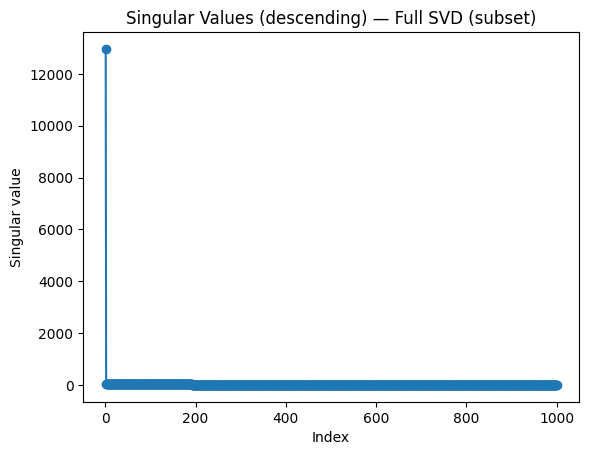

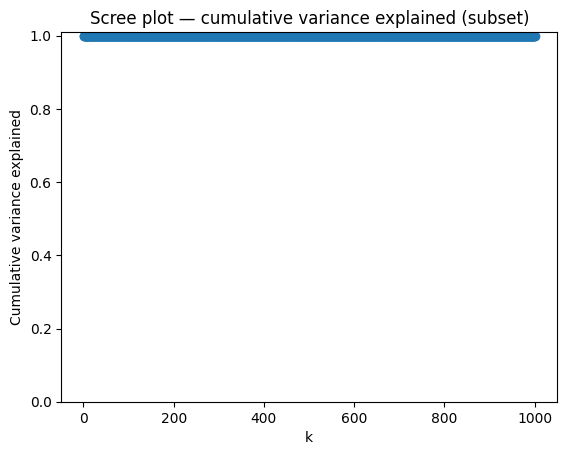

In [37]:
plt.figure()
plt.plot(np.arange(1, len(s_full)+1), s_full, marker="o")
plt.xlabel("Index")
plt.ylabel("Singular value")
plt.title("Singular Values (descending) — Full SVD (subset)")
plt.show()

var = s_full**2
var_ratio = var / var.sum()
cum_var = np.cumsum(var_ratio)

plt.figure()
plt.plot(np.arange(1, len(cum_var)+1), cum_var, marker="o")
plt.xlabel("k")
plt.ylabel("Cumulative variance explained")
plt.title("Scree plot — cumulative variance explained (subset)")
plt.ylim(0, 1.01)
plt.show()



##  3) TRUNCATED SVD (LOW-RANK) TASKS


,k,MAE_all,RMSE_all,MAE_observed,RMSE_observed,variance_retained_ratio,orth_err_UtU,orth_err_VVt,time_sec,mem_delta_mb
0,5,0.021770,0.129693,0.766936,0.998964,0.999067,1.776357e-15,8.881784e-16,0.377741,97.988281
1,20,0.024300,0.123437,0.704387,0.934956,0.999155,1.019150e-15,1.332268e-15,0.623483,1.417969
2,50,0.027206,0.114435,0.619834,0.844695,0.999274,1.776357e-15,2.109424e-15,0.840266,3.542969
3,100,0.030023,0.103089,0.518889,0.731533,0.999411,1.998401e-15,1.998401e-15,0.805798,7.863281


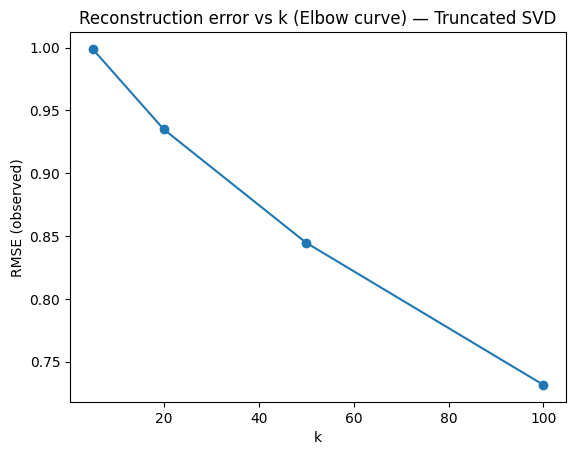

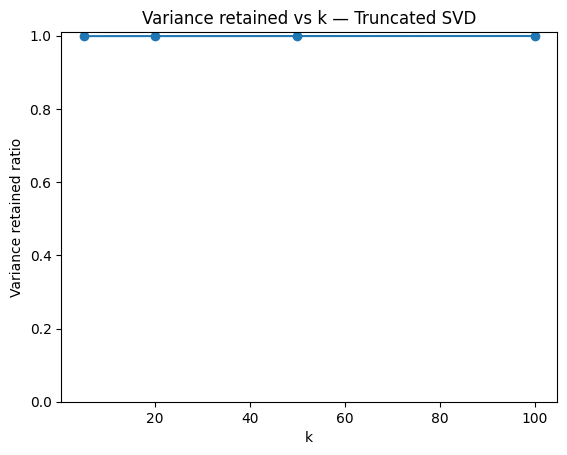

Chosen k_opt (min RMSE observed): 100


In [38]:
K_LIST = [5, 20, 50, 100]
results = []

for k in K_LIST:
    if min(m,n) <= 1:
        break
    kk = int(min(k, min(m,n)-1))  

    t0 = time.time(); mem0 = mem_mb()
    Uk, sk, Vtk = randomized_svd(R, n_components=kk, random_state=RANDOM_SEED)
    Sigmak = np.diag(sk)
    R_hat = Uk @ Sigmak @ Vtk
    t1 = time.time(); mem1 = mem_mb()

    mae_all, rmse_all = mae_rmse(R, R_hat)
    mae_obs, rmse_obs = mae_rmse(R_df.values[observed_mask], R_hat[observed_mask])
    var_ret = variance_retained_ratio_from_fro(sk, R)

    UtU_k = Uk.T @ Uk
    VtV_k = (Vtk @ Vtk.T)
    err_u = float(np.max(np.abs(UtU_k - np.eye(UtU_k.shape[0]))))
    err_v = float(np.max(np.abs(VtV_k - np.eye(VtV_k.shape[0]))))

    results.append({
        "k": kk,
        "MAE_all": mae_all, "RMSE_all": rmse_all,
        "MAE_observed": mae_obs, "RMSE_observed": rmse_obs,
        "variance_retained_ratio": var_ret,
        "orth_err_UtU": err_u, "orth_err_VVt": err_v,
        "time_sec": float(t1-t0),
        "mem_delta_mb": float(mem1-mem0),
    })

svd_k_df = pd.DataFrame(results).sort_values("k")
display(svd_k_df)
plt.figure()
plt.plot(svd_k_df["k"], svd_k_df["RMSE_observed"], marker="o")
plt.xlabel("k")
plt.ylabel("RMSE (observed)")
plt.title("Reconstruction error vs k (Elbow curve) — Truncated SVD")
plt.show()

plt.figure()
plt.plot(svd_k_df["k"], svd_k_df["variance_retained_ratio"], marker="o")
plt.xlabel("k")
plt.ylabel("Variance retained ratio")
plt.title("Variance retained vs k — Truncated SVD")
plt.ylim(0, 1.01)
plt.show()

k_opt = int(svd_k_df.sort_values("RMSE_observed").iloc[0]["k"])
print("Chosen k_opt (min RMSE observed):", k_opt)

##  4) RATING PREDICTION WITH TRUNCATED SVD TASKS


In [39]:
TARGET_USERS_PROVIDED = ['A0040548BPHKXMHH3NTI', 'A100JCBNALJFAW', 'A10175AMUHOQC4']
TARGET_ITEMS_PROVIDED = ['B00PCSVODW', 'B005GISDXW']
users_in_subset = set(R_df.index)
items_in_subset = set(R_df.columns)

target_users = [u for u in TARGET_USERS_PROVIDED if u in users_in_subset]
target_items = [it for it in TARGET_ITEMS_PROVIDED if it in items_in_subset]
if len(target_users) < 3:
    pop_users_in_subset = [u for u in top_users.index if u in users_in_subset]
    target_users = (target_users + pop_users_in_subset)[:3]

if len(target_items) < 2:
    pop_items_in_subset = [it for it in top_items.index if it in items_in_subset]
    target_items = (target_items + pop_items_in_subset)[:2]

print("Target Users:", target_users)
print("Target Items:", target_items)


Target Users: ['A100JCBNALJFAW', 'A10175AMUHOQC4', 'AV6QDP8Q0ONK4']
Target Items: ['B00YSG2ZPA', 'B00006CXSS']


## Predict missing ratings for target pairs

In [40]:
k = int(min(k_opt, min(m,n)-1)) if min(m,n) > 1 else 1
Uk, sk, Vtk = randomized_svd(R, n_components=k, random_state=RANDOM_SEED)
Sigmak = np.diag(sk)

user_to_row = {uid:i for i, uid in enumerate(users_index)}
item_to_col = {iid:j for j, iid in enumerate(items_index)}

pred_rows = []
for uid in target_users:
    for iid in target_items:
        u_vec = Uk[user_to_row[uid], :]      
        v_vec = Vtk[:, item_to_col[iid]]    
        pred = float(u_vec @ Sigmak @ v_vec)

        gt = R_df.loc[uid, iid]  
        pred_rows.append({"user_id": uid, "item_id": iid, "pred_rating": pred, "ground_truth": gt})

pred_table = pd.DataFrame(pred_rows)
display(pred_table)

valid = pred_table["ground_truth"].notna()
if valid.any():
    mae_t, rmse_t = mae_rmse(pred_table.loc[valid,"ground_truth"], pred_table.loc[valid,"pred_rating"])
    print("Target prediction accuracy (on available GT): MAE =", mae_t, "RMSE =", rmse_t)
else:
    print("No ground-truth ratings available for these target pairs (all are missing in sparse matrix).")



,user_id,item_id,pred_rating,ground_truth
0,A100JCBNALJFAW,B00YSG2ZPA,4.837019,NaN
1,A100JCBNALJFAW,B00006CXSS,4.825550,NaN
2,A10175AMUHOQC4,B00YSG2ZPA,4.851149,NaN
3,A10175AMUHOQC4,B00006CXSS,4.842454,NaN
4,AV6QDP8Q0ONK4,B00YSG2ZPA,4.888428,NaN
5,AV6QDP8Q0ONK4,B00006CXSS,4.878025,NaN


No ground-truth ratings available for these target pairs (all are missing in sparse matrix).


## 5) COMPARATIVE ANALYSIS: SVD vs PCA (mean-fill) vs PCA (MLE)


Comparison table (Task 5.4):


,method,k,MAE_all,RMSE_all,MAE_obs,RMSE_obs,runtime_sec,mem_delta_mb
2,PCA MLE (iterative),100,0.112796,0.180390,0.198219,0.308799,12.123549,142.464844
1,PCA mean-fill (global),100,0.029889,0.103093,0.518893,0.731451,1.210607,72.027344
0,Truncated SVD,100,0.030023,0.103089,0.518889,0.731533,1.203219,79.894531


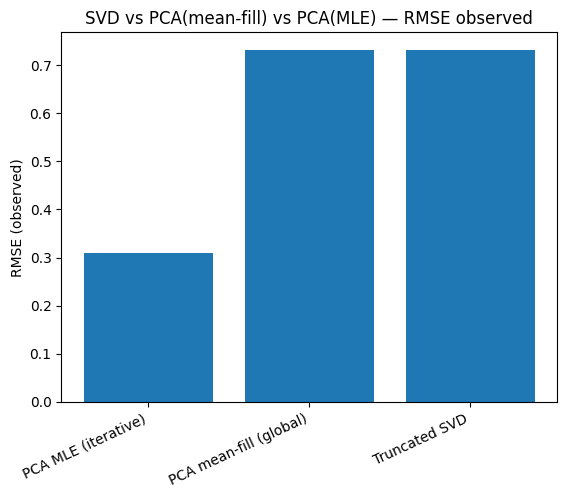

Prediction comparison table (Task 5.2):


,user_id,item_id,ground_truth,pred_svd,pred_pca_mean,pred_pca_mle
0,A100JCBNALJFAW,B00YSG2ZPA,NaN,4.837019,4.842613,4.802144
1,A100JCBNALJFAW,B00006CXSS,NaN,4.825550,4.830843,4.782243
2,A10175AMUHOQC4,B00YSG2ZPA,NaN,4.851149,4.849719,4.865204
3,A10175AMUHOQC4,B00006CXSS,NaN,4.842454,4.840556,4.844969
4,AV6QDP8Q0ONK4,B00YSG2ZPA,NaN,4.888428,4.916452,5.016963
5,AV6QDP8Q0ONK4,B00006CXSS,NaN,4.878025,4.907531,4.984308


In [41]:
def pca_reconstruct(X_filled, k, center="global"):
    X = X_filled.copy()
    if center == "global":
        mu = X.mean()
        Xc = X - mu
        mu_row = None
    elif center == "user":
        mu_row = X.mean(axis=1, keepdims=True)
        Xc = X - mu_row
        mu = None
    else:
        raise ValueError("center must be 'global' or 'user'")

    Uc, sc, Vtc = randomized_svd(Xc, n_components=k, random_state=RANDOM_SEED)
    Xc_hat = Uc @ np.diag(sc) @ Vtc

    return (Xc_hat + mu) if center == "global" else (Xc_hat + mu_row)

def iterative_pca_mle_impute(R_sparse, mask_obs, k, iters=8, center="global"):
    
    X = R_sparse.copy()
    col_mean = np.nanmean(X, axis=0)
    inds = np.where(~mask_obs)
    X[inds] = np.take(col_mean, inds[1])

    for _ in range(iters):
        X_hat = pca_reconstruct(X, k=k, center=center)
        X[~mask_obs] = X_hat[~mask_obs]
    return X


R_sparse = R_df.values.astype(float)  # has NaNs
mask_obs = ~np.isnan(R_sparse)

k_cmp = k
t0=time.time(); mem0=mem_mb()
U_svd, s_svd, Vt_svd = randomized_svd(R, n_components=k_cmp, random_state=RANDOM_SEED)
R_hat_svd = U_svd @ np.diag(s_svd) @ Vt_svd
t1=time.time(); mem1=mem_mb()
svd_time = t1-t0; svd_mem = mem1-mem0

maeA_all, rmseA_all = mae_rmse(R, R_hat_svd)
maeA_obs, rmseA_obs = mae_rmse(R_df.values[observed_mask], R_hat_svd[observed_mask])

t0=time.time(); mem0=mem_mb()
R_hat_pca_mean = pca_reconstruct(R, k=k_cmp, center="global")
t1=time.time(); mem1=mem_mb()
pca_mean_time = t1-t0; pca_mean_mem = mem1-mem0

maeB_all, rmseB_all = mae_rmse(R, R_hat_pca_mean)
maeB_obs, rmseB_obs = mae_rmse(R_df.values[observed_mask], R_hat_pca_mean[observed_mask])

t0=time.time(); mem0=mem_mb()
R_mle_imputed = iterative_pca_mle_impute(R_sparse, mask_obs, k=k_cmp, iters=8, center="global")
R_hat_pca_mle = pca_reconstruct(R_mle_imputed, k=k_cmp, center="global")
t1=time.time(); mem1=mem_mb()
pca_mle_time = t1-t0; pca_mle_mem = mem1-mem0

maeC_all, rmseC_all = mae_rmse(R, R_hat_pca_mle)
maeC_obs, rmseC_obs = mae_rmse(R_df.values[observed_mask], R_hat_pca_mle[observed_mask])

comparison_df = pd.DataFrame([
    {"method":"Truncated SVD", "k":k_cmp,
     "MAE_all":maeA_all, "RMSE_all":rmseA_all, "MAE_obs":maeA_obs, "RMSE_obs":rmseA_obs,
     "runtime_sec":float(svd_time), "mem_delta_mb":float(svd_mem)},
    {"method":"PCA mean-fill (global)", "k":k_cmp,
     "MAE_all":maeB_all, "RMSE_all":rmseB_all, "MAE_obs":maeB_obs, "RMSE_obs":rmseB_obs,
     "runtime_sec":float(pca_mean_time), "mem_delta_mb":float(pca_mean_mem)},
    {"method":"PCA MLE (iterative)", "k":k_cmp,
     "MAE_all":maeC_all, "RMSE_all":rmseC_all, "MAE_obs":maeC_obs, "RMSE_obs":rmseC_obs,
     "runtime_sec":float(pca_mle_time), "mem_delta_mb":float(pca_mle_mem)},
]).sort_values("RMSE_obs")

print("Comparison table (Task 5.4):")
display(comparison_df)

plt.figure()
plt.bar(comparison_df["method"], comparison_df["RMSE_obs"])
plt.xticks(rotation=25, ha="right")
plt.ylabel("RMSE (observed)")
plt.title("SVD vs PCA(mean-fill) vs PCA(MLE) — RMSE observed")
plt.show()

def predict_from_factors(Umat, svals, Vtmat, uid, iid, user_to_row, item_to_col):
    u_vec = Umat[user_to_row[uid], :]
    v_vec = Vtmat[:, item_to_col[iid]]
    return float(u_vec @ np.diag(svals) @ v_vec)

pred_compare_rows = []
for uid in target_users:
    for iid in target_items:
        gt = R_df.loc[uid, iid]  

        pred_svd = predict_from_factors(U_svd, s_svd, Vt_svd, uid, iid, user_to_row, item_to_col)
        pred_pca_mean = float(R_hat_pca_mean[user_to_row[uid], item_to_col[iid]])
        pred_pca_mle  = float(R_hat_pca_mle[user_to_row[uid], item_to_col[iid]])

        pred_compare_rows.append({
            "user_id": uid, "item_id": iid, "ground_truth": gt,
            "pred_svd": pred_svd,
            "pred_pca_mean": pred_pca_mean,
            "pred_pca_mle": pred_pca_mle
        })

pred_compare_df = pd.DataFrame(pred_compare_rows)
print("Prediction comparison table (Task 5.2):")
display(pred_compare_df)


## Cell 13) Task 6.1-6.2: top-3 latent factors (largest singular values)


In [42]:
k_lat = int(max(3, min(k_cmp, min(m,n)-1))) if min(m,n) > 1 else 1
U_lat, s_lat, Vt_lat = randomized_svd(R, n_components=k_lat, random_state=RANDOM_SEED)

TOPN = 10
for f in range(min(3, k_lat)):
    print(f"Latent Factor {f+1} | singular value = {s_lat[f]:.6f}")

    top_items_latent = top_entities_by_abs(Vt_lat[f, :], items_index, topn=TOPN, id_name="item_id")
    top_users_latent = top_entities_by_abs(U_lat[:, f], users_index, topn=TOPN, id_name="user_id")

    print("Top items (highest |V|):")
    display(top_items_latent)

    print("Top users (highest |U|):")
    display(top_users_latent)

print("\nNote: To interpret semantics (e.g., action movies), you need item metadata (categories/titles).")



Latent Factor 1 | singular value = 12964.687825
Top items (highest |V|):


,item_id,value,abs
0,B000FZETI4,0.037254,0.037254
1,B000BMSUBI,0.036757,0.036757
2,B00005JLJE,0.036669,0.036669
3,B000VXK6Z0,0.036576,0.036576
4,B00AKHE40U,0.036426,0.036426
5,7883704559,0.036361,0.036361
6,B00466HN86,0.036243,0.036243
7,0783225857,0.036224,0.036224
8,B009AF5OY8,0.036216,0.036216
9,B00YSG2ZPA,0.036211,0.036211


Top users (highest |U|):


,user_id,value,abs
0,AWG2O9C42XW5G,0.010852,0.010852
1,A2YUA3H1LLU53Z,0.010837,0.010837
2,A3LZBOBV9H1HDV,0.010666,0.010666
3,A35ZK3M8L9JUPX,0.010539,0.010539
4,A35GNQK1DC7WXU,0.010527,0.010527
5,A1SWLQMDCKOZHU,0.010526,0.010526
6,A2H3JURQZOHVMB,0.010509,0.010509
7,A1PGC1GEBY9CZU,0.010505,0.010505
8,A1AFROWZLT4H40,0.010489,0.010489
9,A2GXZX0PTNE9VR,0.010488,0.010488


Latent Factor 2 | singular value = 51.188866
Top items (highest |V|):


,item_id,value,abs
0,B00D91GRA4,-0.203515,0.203515
1,B00M25EALG,-0.198821,0.198821
2,B00V950K3C,-0.198545,0.198545
3,B009934S5M,-0.167478,0.167478
4,B00NYC65M8,-0.157058,0.157058
5,B00EXPOCXY,-0.140988,0.140988
6,B00A6UHC0U,-0.131320,0.131320
7,B00OV3VGP0,-0.129310,0.129310
8,B001GCUO16,-0.128427,0.128427
9,B005LAII4E,-0.126924,0.126924


Top users (highest |U|):


,user_id,value,abs
0,A2I7NGKA8LPN89,0.152514,0.152514
1,A1KIQ4P4ZW3ALF,0.141853,0.141853
2,AWG2O9C42XW5G,-0.139115,0.139115
3,A422TIGQH6GJ5,0.136169,0.136169
4,A3BK4862BVLQ1S,0.125904,0.125904
5,ABO2ZI2Y5DQ9T,0.120304,0.120304
6,AMG88KV31ZIIO,0.114450,0.114450
7,A18GP1PWVTKXQQ,0.100265,0.100265
8,A1XT8AJB7S9JJG,0.099637,0.099637
9,A3LEA9O7LRUW0U,0.095916,0.095916


Latent Factor 3 | singular value = 38.960571
Top items (highest |V|):


,item_id,value,abs
0,B00XQ142MW,-0.559044,0.559044
1,B00YQJRYGY,-0.557263,0.557263
2,B00M25EALG,-0.142712,0.142712
3,B00V950K3C,-0.142487,0.142487
4,B0067EKYDG,0.119156,0.119156
5,B0083UHZK2,0.118675,0.118675
6,B00A7ZH8GM,0.103727,0.103727
7,B00D91GRA4,0.094783,0.094783
8,B005LAIIJY,-0.091631,0.091631
9,B00947NAHU,-0.090912,0.090912


Top users (highest |U|):


,user_id,value,abs
0,AMG88KV31ZIIO,0.173515,0.173515
1,A20J989QAU0H67,0.126144,0.126144
2,A2M687HYOW9JFW,0.111734,0.111734
3,A320FWG10MCXHQ,0.104103,0.104103
4,A27PVVXRXRLIES,0.101649,0.101649
5,A2F880Z6TN9N6H,0.098281,0.098281
6,A38DIX88M5T94P,0.097670,0.097670
7,AYMZTWBG0V53W,0.097211,0.097211
8,A4VR8Q8T99RKM,0.097114,0.097114
9,A3QLAOOTFEHCJI,-0.095496,0.095496



Note: To interpret semantics (e.g., action movies), you need item metadata (categories/titles).


## Cell 14) Task 6.3: visualize latent space (first 2 factors)

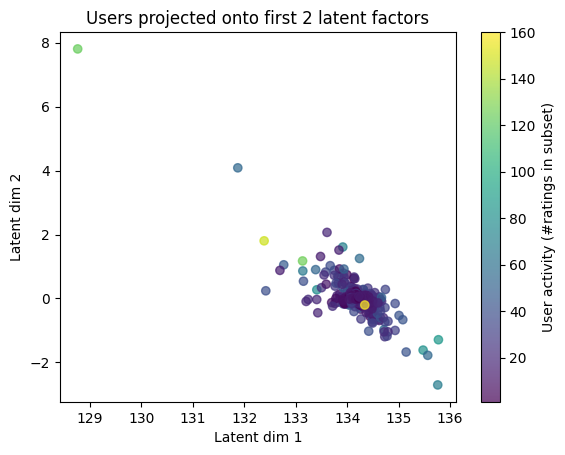

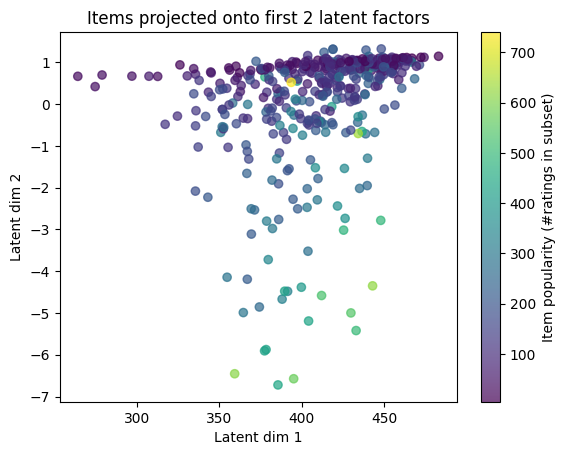

In [43]:
if k_lat >= 2:
    
    user_xy = U_lat[:, :2] * s_lat[:2]            
    item_xy = (Vt_lat[:2, :].T) * s_lat[:2]       

    user_activity = df_sub.groupby("user_id")["rating"].count().reindex(users_index).fillna(0).values
    item_popularity = df_sub.groupby("item_id")["rating"].count().reindex(items_index).fillna(0).values

    max_points = 400
    u_idx = np.random.choice(len(users_index), size=min(max_points, len(users_index)), replace=False)
    i_idx = np.random.choice(len(items_index), size=min(max_points, len(items_index)), replace=False)

    plt.figure()
    sc = plt.scatter(user_xy[u_idx,0], user_xy[u_idx,1], c=user_activity[u_idx], alpha=0.7)
    plt.colorbar(sc, label="User activity (#ratings in subset)")
    plt.xlabel("Latent dim 1")
    plt.ylabel("Latent dim 2")
    plt.title("Users projected onto first 2 latent factors")
    plt.show()

    plt.figure()
    sc = plt.scatter(item_xy[i_idx,0], item_xy[i_idx,1], c=item_popularity[i_idx], alpha=0.7)
    plt.colorbar(sc, label="Item popularity (#ratings in subset)")
    plt.xlabel("Latent dim 1")
    plt.ylabel("Latent dim 2")
    plt.title("Items projected onto first 2 latent factors")
    plt.show()
else:
    print("k_lat < 2: cannot visualize 2D latent space.")



## 8) COLD-START ANALYSIS WITH SVD

In [44]:
subset_user_counts = df_sub.groupby("user_id")["rating"].count()
cold_candidates = subset_user_counts[subset_user_counts > 20].index.to_numpy()

np.random.shuffle(cold_candidates)
cold_users = cold_candidates[:50] if len(cold_candidates) >= 50 else cold_candidates
print("Cold users selected:", len(cold_users))

subset_item_mean = df_sub.groupby("item_id")["rating"].mean()
subset_global_mean = float(df_sub["rating"].mean())

df_cold = df_sub.copy()
hidden_records = []

for uid in cold_users:
    u_rows = df_cold[df_cold["user_id"] == uid]
    if len(u_rows) < 5:
        continue
    hide_n = int(0.8 * len(u_rows))
    hide_idx = u_rows.sample(hide_n, random_state=RANDOM_SEED).index

    hidden_records.append(df_cold.loc[hide_idx, ["user_id","item_id","rating"]])
    df_cold.loc[hide_idx, "rating"] = np.nan

hidden_df = pd.concat(hidden_records, axis=0).reset_index(drop=True) if len(hidden_records) else pd.DataFrame(columns=["user_id","item_id","rating"])
print("Hidden ratings count:", hidden_df.shape[0])

train_df = df_cold.dropna(subset=["rating"]).copy()

R_cold_sparse_df = train_df.pivot_table(index="user_id", columns="item_id", values="rating", aggfunc="mean")
R_cold_sparse_df = R_cold_sparse_df.reindex(index=users_index, columns=items_index)

R_cold_filled_df = R_cold_sparse_df.apply(lambda col: col.fillna(col.mean()), axis=0)
R_cold_filled = R_cold_filled_df.values.astype(np.float64)

m2, n2 = R_cold_filled.shape
k_cs = int(min(k_cmp, min(m2,n2)-1)) if min(m2,n2) > 1 else 1
U_cs, s_cs, Vt_cs = randomized_svd(R_cold_filled, n_components=k_cs, random_state=RANDOM_SEED)
R_hat_cs = U_cs @ np.diag(s_cs) @ Vt_cs

user_to_row_cs = {uid:i for i, uid in enumerate(users_index)}
item_to_col_cs = {iid:j for j, iid in enumerate(items_index)}

pred_rows = []
for _, r in hidden_df.iterrows():
    uid = r["user_id"]; iid = r["item_id"]; gt = float(r["rating"])
    if (uid in user_to_row_cs) and (iid in item_to_col_cs):
        pred_svd = float(R_hat_cs[user_to_row_cs[uid], item_to_col_cs[iid]])
        baseline = float(subset_item_mean.get(iid, subset_global_mean))
        pred_hybrid = 0.7 * pred_svd + 0.3 * baseline

        pred_rows.append([uid, iid, gt, pred_svd, pred_hybrid, baseline])

pred_hidden_df = pd.DataFrame(pred_rows, columns=["user_id","item_id","gt","pred_svd","pred_hybrid","item_mean_baseline"])
display(pred_hidden_df.head(10))

if len(pred_hidden_df) > 0:
    mae_s, rmse_s = mae_rmse(pred_hidden_df["gt"], pred_hidden_df["pred_svd"])
    mae_h, rmse_h = mae_rmse(pred_hidden_df["gt"], pred_hidden_df["pred_hybrid"])

    print("Cold-start performance (SVD): MAE =", mae_s, "RMSE =", rmse_s)
    print("Cold-start performance (Hybrid): MAE =", mae_h, "RMSE =", rmse_h)
else:
    print("No hidden predictions produced (check if cold_users had enough ratings).")

warm_users = [u for u in users_index if u not in set(cold_users)]
if len(warm_users) > 0:
    warm_mask_rows = np.isin(users_index, warm_users)
    observed_mask_coldtrain = ~R_cold_sparse_df.isna().values

    true_warm = R_df.values[warm_mask_rows][:, :][observed_mask[warm_mask_rows][:, :]]
    pred_warm = R_hat_cs[warm_mask_rows][:, :][observed_mask[warm_mask_rows][:, :]]

    if len(true_warm) > 0:
        mae_w, rmse_w = mae_rmse(true_warm, pred_warm)
        print("Warm-start (non-cold users) on observed ratings — MAE:", mae_w, "RMSE:", rmse_w)
else:
    print("No warm users found in subset.")



Cold users selected: 50
Hidden ratings count: 1276


,user_id,item_id,gt,pred_svd,pred_hybrid,item_mean_baseline
0,A1OH0GXCXPZ6MK,B0000YTP02,5.0,4.676993,4.663532,4.632124
1,A1OH0GXCXPZ6MK,B00DJYJWVW,5.0,3.854320,3.836106,3.793605
2,A1OH0GXCXPZ6MK,B00005PJ8O,5.0,4.844525,4.839982,4.829384
3,A1OH0GXCXPZ6MK,B004EPYZUS,5.0,4.356300,4.339976,4.301887
4,A1OH0GXCXPZ6MK,6300213803,5.0,4.704937,4.705321,4.706215
5,A1OH0GXCXPZ6MK,B000YAF4MA,5.0,4.163716,4.144415,4.099379
6,A1OH0GXCXPZ6MK,B002HEXVUI,5.0,4.244545,4.239603,4.228070
7,A1OH0GXCXPZ6MK,B004EPYZP8,5.0,4.434329,4.427475,4.411483
8,A1OH0GXCXPZ6MK,B000W07EKW,5.0,4.709759,4.711523,4.715640
9,A1OH0GXCXPZ6MK,B000W07EKW,5.0,4.709759,4.711523,4.715640


Cold-start performance (SVD): MAE = 0.7366690852734716 RMSE = 0.9490839349165736
Cold-start performance (Hybrid): MAE = 0.7390699629631922 RMSE = 0.9493371933749097
Warm-start (non-cold users) on observed ratings — MAE: 0.5191105009379724 RMSE: 0.731674681212242


## ell 16) Task 8.3 "acceptable performance vs ratings"

,observed_ratings_per_user,MAE,RMSE,num_hidden_eval
0,1,0.737363,0.938875,1569
1,2,0.732340,0.932783,1519
2,3,0.726076,0.922509,1469
3,4,0.723105,0.920775,1419
4,5,0.720026,0.917460,1369
5,6,0.715635,0.909277,1319
6,7,0.710007,0.903024,1269
7,8,0.703984,0.893684,1219
8,9,0.698921,0.889691,1169
9,10,0.699327,0.891271,1119


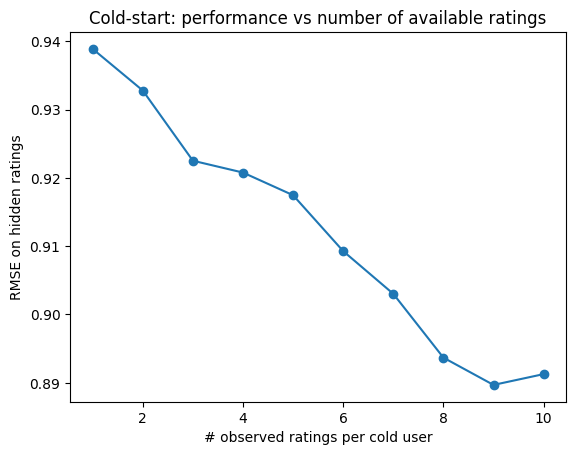

In [45]:
def cold_start_eval_with_r_observed(r_obs=3):
    df_tmp = df_sub.copy()
    hidden_list = []

    for uid in cold_users:
        u_rows = df_tmp[df_tmp["user_id"] == uid]
        if len(u_rows) <= r_obs:
            continue

        keep = u_rows.sample(r_obs, random_state=RANDOM_SEED).index
        hide = u_rows.index.difference(keep)

        hidden_list.append(df_tmp.loc[hide, ["user_id","item_id","rating"]])
        df_tmp.loc[hide, "rating"] = np.nan

    hidden_tmp = pd.concat(hidden_list, axis=0).reset_index(drop=True) if len(hidden_list) else pd.DataFrame(columns=["user_id","item_id","rating"])
    train_tmp = df_tmp.dropna(subset=["rating"]).copy()

    R_tmp_sparse = train_tmp.pivot_table(index="user_id", columns="item_id", values="rating", aggfunc="mean")
    R_tmp_sparse = R_tmp_sparse.reindex(index=users_index, columns=items_index)
    R_tmp_filled = R_tmp_sparse.apply(lambda col: col.fillna(col.mean()), axis=0).values.astype(np.float64)


    U_t, s_t, Vt_t = randomized_svd(R_tmp_filled, n_components=k_cs, random_state=RANDOM_SEED)
    Rhat_t = U_t @ np.diag(s_t) @ Vt_t

    rows = []
    for _, rr in hidden_tmp.iterrows():
        uid = rr["user_id"]; iid = rr["item_id"]; gt = float(rr["rating"])
        if (uid in user_to_row_cs) and (iid in item_to_col_cs):
            pred = float(Rhat_t[user_to_row_cs[uid], item_to_col_cs[iid]])
            rows.append([gt, pred])

    if len(rows) == 0:
        return np.nan, np.nan, 0

    arr = np.array(rows)
    mae, rmse = mae_rmse(arr[:,0], arr[:,1])
    return mae, rmse, len(rows)

r_list = list(range(1, 11))
acc_rows = []
for r_obs in r_list:
    mae_r, rmse_r, n_eval = cold_start_eval_with_r_observed(r_obs=r_obs)
    acc_rows.append({"observed_ratings_per_user": r_obs, "MAE": mae_r, "RMSE": rmse_r, "num_hidden_eval": n_eval})

acceptable_df = pd.DataFrame(acc_rows)
display(acceptable_df)

plt.figure()
plt.plot(acceptable_df["observed_ratings_per_user"], acceptable_df["RMSE"], marker="o")
plt.xlabel("# observed ratings per cold user")
plt.ylabel("RMSE on hidden ratings")
plt.title("Cold-start: performance vs number of available ratings")
plt.show()
